<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block> 
        <font size=3>Homework 3</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:aliizadi2030@gmail.com">Ali Izadi</a><br></font><br>
    </div>
</div>

# Part 1: Score matching

# 1-1 load dataset


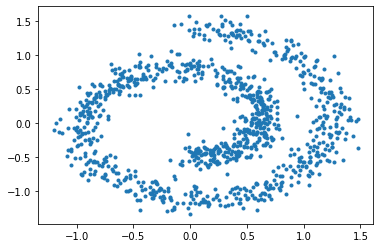

In [1]:
import torch
from sklearn.datasets import make_swiss_roll
import numpy as np

# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

# show the samples
import matplotlib.pyplot as plt
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

# 1-2 Neural Network for: $\mathbf{s_\theta}(\mathbf{x})$

In [2]:
# score_network takes input of 2 dimension and returns the output of the same size
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

# 1-3 Score Matching


Now let's implement the first and second terms of the loss function below,
$$\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{x})\right\rVert^2 + \mathrm{tr}\left(\nabla_\mathbf{x} \mathbf{s_\theta}(\mathbf{x})\right)\right].
\end{equation}$$
To get the Jacobian, you can use the function from ``functorch`` or other methods you prefer.

In [3]:
!pip install functorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 887.4/887.4 MB 191.4 MB/s eta 0:00:01tcmalloc: large alloc 1109270528 bytes == 0x37b3c000 @  0x7ff8b9fc1615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0

In [4]:
from functorch import jacrev, vmap

def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_network(x)  # score: (batch_size, 2)
    
    ################################################################################
    # TODO: complete the code here for computing score matching L

    # first term: half of the squared norm

    first_term = torch.norm(score, dim=-1) ** 2 / 2.
  
    # second term: trace of the Jacobian
  
    compute_batch_jacobian = vmap(jacrev(score_network))(data)
    second_term = torch.einsum('bii->b', compute_batch_jacobian)

    # return loss = first term + second term
    
    loss = (first_term + second_term).mean(-1)

    return loss

    # End 
    ################################################################################


# 1-4 Training

Everything is ready, now we can start the training. In my computer, it takes about 10-15 minutes to finish.

In [5]:
# start the training loop
import time
losses = []
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True)
t0 = time.time()
for i_epoch in range(5000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 500 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")
        losses.append(total_loss / len(dset))


0 (0.6749043464660645s): -0.03490829949080944
500 (74.31553483009338s): -26.01145487976074
1000 (142.8601553440094s): -41.993974853515624
1500 (211.9807252883911s): -48.28126016235352
2000 (285.726450920105s): -54.663706787109376
2500 (356.91866278648376s): -59.331869262695314
3000 (429.0530695915222s): -64.89136978149413
3500 (501.9082136154175s): -66.8564017944336
4000 (574.1397924423218s): -69.93992919921875
4500 (649.2152736186981s): -72.45507510375977


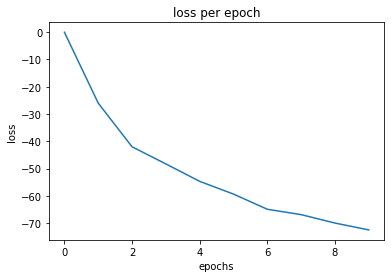

In [6]:
plt.plot(range(0,len(losses)), losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss per epoch")
plt.show();

In [7]:
torch.save(score_network.state_dict(), 'ct_final_1.pth')

# 1-5 Generation

Once the neural network is trained, we can generate the samples using Langevin dynamics.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \varepsilon \nabla_\mathbf{x}\mathrm{log}\ p(\mathbf{x}) + \sqrt{2\varepsilon} \mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

In [8]:
import numpy as np
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 100) -> torch.Tensor:
     
    ################################################################################
    # TODO: complete the code here
    # generate samples using Langevin dynamics and return samples
    
    x = torch.normal(0, 1 , size = (nsamples,2))
    for n in range(nsteps):
      z_t = torch.normal(0, 1 , size = (nsamples,2))
      x = x + (eps * score_net(x) ) + (np.sqrt(2*eps) * z_t)
    
    return x
    # End 
    ################################################################################

samples = generate_samples(score_network, 1000).detach()
    

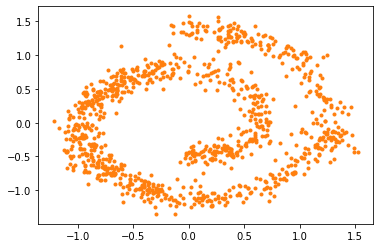

In [9]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')

# Part 2: Denoising Score matching

# 2-1 Noise conditional Neural Network

Now let’s define the neural network that will learn the score function. This is just a simple multi-layer perceptron with LogSigmoid activation function. In contrast to the previous part, the neural network here takes n+1 inputs and produces n outputs. The additional 1 input is for the noise in $t_i$

In [ ]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)


# 2-3 Score Matching

Now let's implement the first and second terms of the loss function below,
$$\begin{equation}
\mathcal{L}(\theta) = \frac{1}{L}\sum_{i=1}^{L}{λ(σ_i)}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{\tilde{x}}\sim q_{σ_i}(\mathbf{\tilde{x}|x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{\tilde{x}, σ_i}) - \nabla_\mathbf{\tilde{x}} \mathbf{log q_{σ_i}}(\mathbf{\tilde{x}|x})\right\rVert^2\right]
\end{equation}$$

$$\begin{equation}
=\frac{1}{L}\sum_{i=1}^{L}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})}\left[\frac{1}{2} \left\lVert\mathbf{\sigma_i s_\theta}(\mathbf{x+σ_iz, σ_i})+ z\right\rVert^2\right] + const.
\end{equation}$$


In [ ]:
sigmas = torch.linspace(0.001, 0.04, steps=1000)


def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    
    # sample the time

    ################################################################################
    # TODO: complete the code here for computing denoising score matching L
    
    # use sigmas variable on top of funcion calc_loss to compute denoising score matching L
    
    z = torch.normal(0, 1 , size = (data.size(0),2))
    perm = torch.randperm(sigmas.size(0))
    idx = perm[:data.size(0)]
    sigma = sigmas[idx].reshape((x.size(0),1))
    L = torch.norm((sigma * score_network(torch.cat((data + sigma * z, sigma), 1)) + z), dim=-1)** 2 / 2.
   
  
    return L.mean(-1)
    # End (return loss)
    ################################################################################


# 2-4 Training

Everything’s ready, so we can start the training. It takes about 20 - 25 minutes to complete the training.

In [ ]:
# start the training loop
import time
losses = []
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
for i_epoch in range(150000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 10000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")
        losses.append(total_loss / len(dset))


0 (0.020824909210205078s): 1.0255581359863282
10000 (118.04498839378357s): 0.9653635535240174
20000 (294.98042273521423s): 0.9418165102005005
30000 (468.1212315559387s): 1.005534345626831
40000 (634.4655869007111s): 0.9615284471511841
50000 (801.732382774353s): 0.9737320804595947
60000 (968.8870463371277s): 0.9553116064071655
70000 (1133.1938872337341s): 0.9388961472511291
80000 (1293.0862724781036s): 0.9731570239067078
90000 (1454.3460309505463s): 1.0024056372642518
100000 (1611.457025527954s): 0.9394016885757446
110000 (1768.6599657535553s): 0.9195040607452393
120000 (1926.3183681964874s): 0.9730404138565063
130000 (2082.3645815849304s): 0.9737058520317078
140000 (2240.14604473114s): 0.9555389165878296


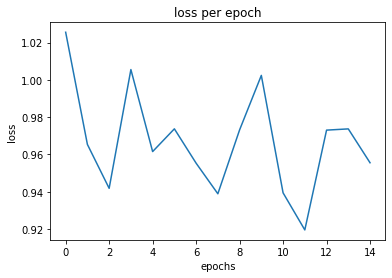

In [ ]:
plt.plot(range(0,len(losses)), losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss per epoch")
plt.show();

In [ ]:
torch.save(score_network.state_dict(), 'ct_final_2.pth')

In [ ]:
torch.save(score_network.state_dict(), 'ct3.pth')

In [ ]:
load = torch.load("/content/ct3.pth")

In [ ]:
score_network.load_state_dict(load)

<All keys matched successfully>

In [ ]:
sigmas = torch.linspace(0.001, 0.04, steps=1000)

# 2-5 Generation

Once the neural network is trained, we can generate the samples using Annealed Langevin dynamics.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \frac{α_i}{2}\mathbf{s_\theta}(\mathbf{x+σ_iz, σ_i}) + \sqrt{\alpha_i}\mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

and $\mathbf{α_i=ϵ.\frac{σ_i}{σ_L}}$




In [ ]:
reverse_sigmas = torch.flip(sigmas, dims=(0,))

def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:

    ################################################################################
    # TODO: complete the code here
    # generate samples using Annealed Langevin dynamics and return samples
    
    # use sigmas variable on top of funcion calc_loss to implement Annealed Langevin dynamics
    x = torch.normal(0, 1 , size = (nsamples,2))
    
    #reverse_sigmas = torch.flip(sigmas, dims=(0,))

    for s in range(reverse_sigmas.shape[0]):


      alpha = (1/1000000) * ((reverse_sigmas[s]**2 )/(reverse_sigmas[-1]**2))
      #print(alpha)
      sigma = reverse_sigmas[s].expand(x.size(0)).reshape((x.size(0),1))
      #print("sigma :", sigma.shape)
      z = torch.normal(0, 1 , size = (x.size(0),2))
      #print("z :",z)
      #print("fff",x + (sigma * z))
      x = x + ((alpha/2) * score_network(torch.cat((x , sigma ), 1)) )+ (np.sqrt(alpha) * z )
      #print("x ;" ,x)
       
    return x
    # End (return samples)
    ################################################################################

samples = generate_samples(score_network, 1000).detach()


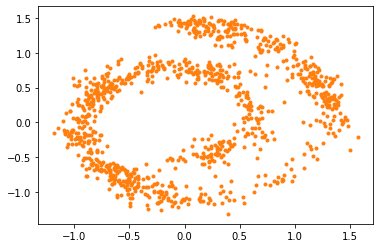

In [ ]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')